# TrackPy set-up to track wrinkles in webs
### For questions/concerns contact Robert Hutton, sam@samhutton.net 


- The videos are recorded from an arial perspective, which allows the camera to see the downstream roller and the upstream roller, as well as the "troughs" in-between


<p float="left">
  <img src="first vids/test1/out-001.png" width="500" />
</p>

- We will be requiring the following libraries:

In [646]:
#namespace imports for openCV, pims, and trackpy
import csv
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pims
import trackpy as tp
import moviepy
import skimage.exposure as exposure
from PIL import Image
import seaborn as sns


First, use FFMPEG to slice the video into frames saved as png image files. save to the working directory.

It is important to note the width of the span in the file name!! since the roller is no longer in the picture as a calibration distance.

- Now we run the blur and Canny edge algorithms
- The Canny algorith is composed of 5 main steps:
- 1. Noise reduction is performed with a 5x5 Gaussian filter, this large filter eliminates the background edges
- 2. The intensity if filtered with a Sobel kernel in both directions which results in the ability to find the edge gradient and direction of each pixel
- 3. A full scan of the image is done to remove pixels which do not constitute an edge
- 4. Hysteresis thresholding is performed to filter edges which are above or below ad max or min intensity values, respectively

In [647]:
# #define the resolution for openCV

# def set_res(cap, width, height):
#     cap.set(3, width)
#     cap.set(4, height)

# cap = cv.VideoCapture(0)
# set_res(cap, 1920, 1080)

1080
1080


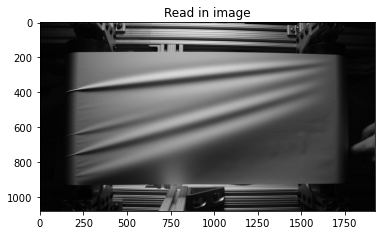

In [648]:
#open the first image of the sequence and apply gaussian blur
img = cv.imread('first vids/test1/out-050.png')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #grayscale

print(len(img))


blur = cv.blur(img,(3,3))
print(len(blur))

plt.imshow(img,cmap = 'gray')
plt.title('Read in image')
plt.show()

In [649]:
# #its best if we adjust the brightness and contrast here before further processing
# new_image = np.zeros(img.shape, img.dtype)
# alpha = 1.0 # contrast control
# beta = 0    # brightness control
# print(img.shape[0],img.shape[1],img.shape[2])
# for y in range(img.shape[0]):
#     for x in range(img.shape[1]):
#         for c in range(img.shape[2]):
#             new_image[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
# plt.imshow(new_image,cmap = 'gray')
# plt.title('post-adjustment'), plt.xticks([]), plt.yticks([])
# plt.show()

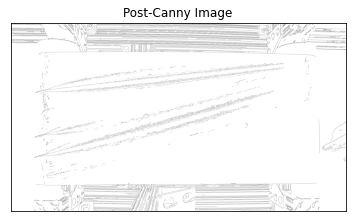

In [650]:
#here we test the output using Canny edge detection
edges = cv.Canny(blur,threshold1=0, threshold2=25) #call openCV Canny filter with inputs: (img, lower threshold, upper threshold
plt.imshow(edges,cmap = 'Greys')
plt.title('Post-Canny Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [651]:
#here we test the output using Sobel edge detection
sobelx = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=1, dy=0, ksize=15) # Sobel Edge Detection on the X axis
sobely = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=0, dy=1, ksize=15) # Sobel Edge Detection on the Y axis
sobelxy = cv.Sobel(src=blur, ddepth=cv.CV_64F, dx=1, dy=1, ksize=15)

sobelx2 = cv.multiply(sobelx,sobelx)
sobely2 = cv.multiply(sobely,sobely)
sobel_magnitude = cv.sqrt(sobelx2 + sobely2)
sobel_magnitude = exposure.rescale_intensity(sobel_magnitude, in_range='image', out_range=(0,255)).clip(0,255).astype(np.uint8)

# optionally normalize to range 0 to 255 for proper display
sobelx_norm= exposure.rescale_intensity(sobelx, in_range='image', out_range=(0,255)).clip(0,255).astype(np.uint8)
sobely_norm= exposure.rescale_intensity(sobelx, in_range='image', out_range=(0,255)).clip(0,255).astype(np.uint8)

# save results
cv.imwrite('sobel_magnitude.jpg', sobel_magnitude)

# show results
cv.imshow('sobel_magnitude', sobel_magnitude)  

#since the troughs are still a bit blurry for tracking, implement sharpening by convolving the image with a sharpening kernel
kernel = np.array([ [-1,-1,-1], 
                    [-1, 21,-1],
                    [-1,-1,-1]])
sharpened = cv.filter2D(sobel_magnitude, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
cv.imwrite('Image Sharpening.jpg', sharpened)

True

- now we apply the above processing steps to all of the images in the series

In [652]:
#pims method for pulling color channels, its fine to just use a single channel here, in this case we use the green channel
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

#opens the series of png images as a series of frames. the * denotes all files with .png sequentially
frames = gray(edges)
plt.imshow(frames[0]) #plot the first frame for a visual check

#the image should already be pre-processed, but here we refine the crop to be X pixels tall, so that the tracked point is uniform height
def crop(img):
    x_min = 0
    x_max = 1300
    y_min = 300
    y_max = 400
    return img[y_min:y_max,x_min:x_max]

rawframes = pims.ImageSequence(os.path.join(datapath, prefix + '*.png'), process_func=crop)
plt.imshow(rawframes[id_example])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed